# Cneuromod validation

https://docs.cneuromod.ca/en/latest/DATASETS.html#hcptrt

This cneuromod dataset is called HCP test-retest (hcptrt), because participants repeated 15 times the functional localizers developed by the Human Connectome Project, for a total of approximately 10 hours of functional data per subject.

In [2]:
import pandas as pd
import numpy as np
import nibabel as nib
nib.imageglobals.logger.setLevel(40)

np.set_printoptions(suppress=True)
from glob import glob

from matplotlib import pyplot as plt
from lib.plotting import plot_29k
import hcp_utils as hcp 

from collections import defaultdict
def mydefault():
  return defaultdict(mydefault);

from IPython.display import clear_output
from lib.plotting import plot_gen_surf2, image_grid, fig2tightPIL


/usr/users/robert.scholz2/.local/lib/python3.9/site-packages/nilearn/datasets/__init__.py:93: FutureWarning: Fetchers from the nilearn.datasets module will be updated in version 0.9 to return python strings instead of bytes and Pandas dataframes instead of Numpy arrays.
  warn("Fetchers from the nilearn.datasets module will be "


In [3]:
"""for name, value in os.environ.items():
    if "SLURM" in name: 
      print("{0}: {1}".format(name, value))"""

import os
from datetime import datetime
ts = int(os.environ["SLURM_JOB_END_TIME"])
print(datetime.utcfromtimestamp(ts).strftime('%Y-%m-%d %H:%M:%S'))

2024-09-04 17:42:31


**default params**

In [23]:
# Find all subjects
"""subj_dirs = glob(f"{dataset_dir}/fmriprep/hcptrt/sub-*/")
subj_dirs.sort();
cneuro_subjs = [p.split("/")[-2] for p in subj_dirs]
np.savetxt("data/subjs_cneuro6.txt", cneuro_subjs, fmt="%s")"""
cneuro_subjs=np.loadtxt("data/subjs_cneuro6.txt", dtype=str)
print("Subjects:", cneuro_subjs)

from lib.default_config import  contrast_info
tasks = np.unique([c[0] for c in contrast_info]).tolist()
print("Tasks:",tasks)

unique_contrasts = np.loadtxt("data/task_contrasts_47_unique_names.txt", dtype=str);
contrast_ids_to_show = [8, 38, 16, 2, 27, 24, 5, 44, 21]
contrast_names = unique_contrasts[contrast_ids_to_show]
tnames_mid = ["Lang S-M", "WM2-0", "Motor Cue-Avg", "Emoti Face-Shape", "Social TOM-Rand", "Rel-Match", "Gamble Rew-Pun" ,"WM Face-Av", "Motor T-Avg"]
print("Contrasts:", contrast_names)

dataset_dir= "/scratch/users/robert.scholz2/cneuroprep"

cneuro_subjs_x = ['sub-01', 'sub-03', 'sub-05']

Subjects: ['sub-01' 'sub-02' 'sub-03' 'sub-04' 'sub-05' 'sub-06']
Tasks: ['EMOTION', 'GAMBLING', 'LANGUAGE', 'MOTOR', 'RELATIONAL', 'SOCIAL', 'WM']
Contrasts: ['LANGUAGE_STORY-MATH' 'WM_2BK-0BK' 'MOTOR_CUE-AVG' 'EMOTION_FACES-SHAPES'
 'SOCIAL_TOM-RANDOM' 'RELATIONAL_REL-MATCH' 'GAMBLING_REWARD-PUNISH'
 'WM_FACE-AVG' 'MOTOR_T-AVG']


# Download Cneuromod data

common issue: S3 bucket does not allow public access. Then set the access keys in your `bash` terminal everytime you want to download data:

`export AWS_ACCESS_KEY_ID=<s3_access_key>`

`AWS_SECRET_ACCESS_KEY=<s3_secret_key>`


In [3]:
# run directly on the cluster to get the git repository and file metadata
"""
cd /scratch/users/robert.scholz2/cneuroprep
datalad get -n $scratch/cneuroprep/fmriprep/hcptrt/
datalad get -n smriprep""";

## Download task run data

In [69]:
# list sample files
subj = cneuro_subjs[0]
task = tasks[0].lower()
cifti_files = glob(f"{dataset_dir}/fmriprep/hcptrt/{subj}/ses-0*/func/*{task}_run-1*.dtseries.nii")
event_files = glob(f"{dataset_dir}/fmriprep/hcptrt/sourcedata/hcptrt/{subj}/ses-0*/func/*{task}_run-01*events.tsv")
event_files.sort(); cifti_files.sort();
for f in cifti_files[:4]: print(f[len(dataset_dir):])
for f in event_files[:4]: print(f[len(dataset_dir):])

/fmriprep/hcptrt/sub-01/ses-002/func/sub-01_ses-002_task-emotion_run-1_space-fsLR_den-91k_bold.dtseries.nii
/fmriprep/hcptrt/sub-01/ses-003/func/sub-01_ses-003_task-emotion_run-1_space-fsLR_den-91k_bold.dtseries.nii
/fmriprep/hcptrt/sub-01/ses-004/func/sub-01_ses-004_task-emotion_run-1_space-fsLR_den-91k_bold.dtseries.nii
/fmriprep/hcptrt/sub-01/ses-005/func/sub-01_ses-005_task-emotion_run-1_space-fsLR_den-91k_bold.dtseries.nii
/fmriprep/hcptrt/sourcedata/hcptrt/sub-01/ses-002/func/sub-01_ses-002_task-emotion_run-01_events.tsv
/fmriprep/hcptrt/sourcedata/hcptrt/sub-01/ses-003/func/sub-01_ses-003_task-emotion_run-01_events.tsv
/fmriprep/hcptrt/sourcedata/hcptrt/sub-01/ses-004/func/sub-01_ses-004_task-emotion_run-01_events.tsv
/fmriprep/hcptrt/sourcedata/hcptrt/sub-01/ses-005/func/sub-01_ses-005_task-emotion_run-01_events.tsv


In [73]:
# function to make sure we have corresponding mri data and events files
import re

def get_all_attr(string, attr=["sub", "ses", "task", "run"], ret_slice = 0):
  data = []
  for a in attr: 
    res = re.findall(a + r'-[a-zA-Z0-9]+', string)
    data.append(res[ret_slice].replace("run-0", "run-"))  # with hotfix
  return np.array(data);

print(get_all_attr(cifti_files[0]))
print(get_all_attr(event_files[0]))
assert np.all(get_all_attr(cifti_files[0]) ==get_all_attr(event_files[0]))

['sub-01' 'ses-002' 'task-emotion' 'run-1']
['sub-01' 'ses-002' 'task-emotion' 'run-1']


In [74]:
runs, events, attr = [defaultdict(mydefault) for i in range(3)]

for subj in cneuro_subjs:
  print("\n", subj, end=": ");
  for task in tasks:
    cifti_files = glob(f"{dataset_dir}/fmriprep/hcptrt/{subj}/ses-0*/func/*{task.lower()}*.dtseries.nii")    
    event_files = glob(f"{dataset_dir}/fmriprep/hcptrt/sourcedata/hcptrt/{subj}/ses-0*/func/*{task.lower()}*events.tsv")
    event_files.sort(); cifti_files.sort();
    run_attrs = [get_all_attr(cifti_files[i]) for i in range(4)];
    evn_attrs = [get_all_attr(cifti_files[i]) for i in range(4)];
    print(task, len(cifti_files), len(event_files), end=", ")
    assert np.all(np.array(run_attrs) == np.array(evn_attrs))
    runs[subj][task]   = cifti_files
    events[subj][task] = event_files
    attr[subj][task]   = run_attrs
    
np.save("data/cneuromod_task_run_info.npy", dict(runs=runs, events=events, attr=attr, subjs = cneuro_subjs, tasks= tasks))


 sub-01: EMOTION 14 14, GAMBLING 15 15, LANGUAGE 14 14, MOTOR 15 15, RELATIONAL 14 14, SOCIAL 15 15, WM 15 15, 
 sub-02: EMOTION 15 15, GAMBLING 15 15, LANGUAGE 15 15, MOTOR 15 15, RELATIONAL 15 15, SOCIAL 15 15, WM 15 15, 
 sub-03: EMOTION 15 15, GAMBLING 15 15, LANGUAGE 15 15, MOTOR 15 15, RELATIONAL 15 15, SOCIAL 15 15, WM 15 15, 
 sub-04: EMOTION 14 14, GAMBLING 14 14, LANGUAGE 14 14, MOTOR 14 14, RELATIONAL 14 14, SOCIAL 14 14, WM 14 14, 
 sub-05: EMOTION 14 14, GAMBLING 14 14, LANGUAGE 14 14, MOTOR 14 14, RELATIONAL 14 14, SOCIAL 14 14, WM 14 14, 
 sub-06: EMOTION 18 18, GAMBLING 17 17, LANGUAGE 18 18, MOTOR 18 18, RELATIONAL 17 17, SOCIAL 14 14, WM 18 18, 

**now to the actual download using datalad**

* cd /scratch/users/robert.scholz2/cneuroprep
* datalad get .../sub-01/ses-002/func/sub-01_ses-002_task-language_run-01_events.tsv
* datalad get fmriprep/hcptrt/sub-01/ses-002/func/sub-01_ses-002_task-language_run-1_space-fsLR_den-91k_bold.dtseries.nii
* cat fmriprep/hcptrt/sub-01/ses-002/func/sub-01_ses-002_task-language_run-1_space-fsLR_den-91k_bold.json
  + { "DelayTime": 0.11749999999999994,  "RepetitionTime": 1.49 }

In [72]:
cifti_files = []
event_files = []

n_runs=8

for subj in cneuro_subjs:
  for task in tasks:
    cifti_files = cifti_files + runs[subj][task][:n_runs]
    event_files = event_files + events[subj][task][:n_runs]
    #print(attr[subj][task])

dataladstr = ""#"datalad get "
for f in cifti_files: dataladstr += f[len(dataset_dir)+1:] + " "
for f in event_files: dataladstr += f[len(dataset_dir)+1:] + " "
print("cd /scratch/users/robert.scholz2/cneuroprep")
print(dataladstr[:500], "...")

# writing to a file
text_file = open("data/cneuro_taskrun_downloads.txt", "w")
text_file.write(dataladstr)
text_file.close()

# full data can be downloaded using datalad
# datalad get $(<$HOME/code/dist_model/data/cneuro_taskrun_downloads.txt)

cd /scratch/users/robert.scholz2/cneuroprep
fmriprep/hcptrt/sub-01/ses-002/func/sub-01_ses-002_task-emotion_run-1_space-fsLR_den-91k_bold.dtseries.nii fmriprep/hcptrt/sub-01/ses-002/func/sub-01_ses-002_task-emotion_run-2_space-fsLR_den-91k_bold.dtseries.nii fmriprep/hcptrt/sub-01/ses-003/func/sub-01_ses-003_task-emotion_run-1_space-fsLR_den-91k_bold.dtseries.nii fmriprep/hcptrt/sub-01/ses-004/func/sub-01_ses-004_task-emotion_run-1_space-fsLR_den-91k_bold.dtseries.nii fmriprep/hcptrt/sub-01/ses-005/func/sub-01_ses-005_task-emotion_run-1_sp ...


In [15]:
# make sure the download was successful

import os
n_existing_runs = 0;
for i, f in enumerate(cifti_files):
  exists= os.path.exists(f);
  if exists: 
    n_existing_runs+=1
    print(exists, i,  "\t", f[50:])

print(f"----\n{n_existing_runs} of {len(cifti_files)}")

True 0 	 hcptrt/sub-01/ses-002/func/sub-01_ses-002_task-language_run-1_space-fsLR_den-91k_bold.dtseries.nii
True 1 	 hcptrt/sub-01/ses-002/func/sub-01_ses-002_task-language_run-2_space-fsLR_den-91k_bold.dtseries.nii
True 2 	 hcptrt/sub-01/ses-003/func/sub-01_ses-003_task-language_run-1_space-fsLR_den-91k_bold.dtseries.nii
True 3 	 hcptrt/sub-01/ses-004/func/sub-01_ses-004_task-language_run-1_space-fsLR_den-91k_bold.dtseries.nii
True 4 	 hcptrt/sub-01/ses-005/func/sub-01_ses-005_task-language_run-1_space-fsLR_den-91k_bold.dtseries.nii
True 5 	 hcptrt/sub-01/ses-005/func/sub-01_ses-005_task-language_run-2_space-fsLR_den-91k_bold.dtseries.nii
True 6 	 hcptrt/sub-01/ses-006/func/sub-01_ses-006_task-language_run-1_space-fsLR_den-91k_bold.dtseries.nii
True 7 	 hcptrt/sub-01/ses-006/func/sub-01_ses-006_task-language_run-2_space-fsLR_den-91k_bold.dtseries.nii
----
8 of 90


## Download resting state runs

In [16]:
rs_runs = defaultdict(mydefault)

for subj in cneuro_subjs:
   rs_files = glob(f"{dataset_dir}/fmriprep/hcptrt/{subj}/ses-*/func/*restingstate*.dtseries.nii")
   rs_files.sort()
   rs_runs[subj] = rs_files;
   for f in rs_files:
    print(os.path.exists(f), "\t", subj, len(rs_files), "\t", f[50:])
    
#np.save("data/cneuromod_rs_run_info.npy", dict(rs_runs=rs_runs, subjs = cneuro_subjs))

True 	 sub-01 5 	 hcptrt/sub-01/ses-001/func/sub-01_ses-001_task-restingstate_run-1_space-fsLR_den-91k_bold.dtseries.nii
False 	 sub-01 5 	 hcptrt/sub-01/ses-003/func/sub-01_ses-003_task-restingstate_run-1_space-fsLR_den-91k_bold.dtseries.nii
False 	 sub-01 5 	 hcptrt/sub-01/ses-004/func/sub-01_ses-004_task-restingstate_run-1_space-fsLR_den-91k_bold.dtseries.nii
False 	 sub-01 5 	 hcptrt/sub-01/ses-007/func/sub-01_ses-007_task-restingstate_run-1_space-fsLR_den-91k_bold.dtseries.nii
False 	 sub-01 5 	 hcptrt/sub-01/ses-009/func/sub-01_ses-009_task-restingstate_run-1_space-fsLR_den-91k_bold.dtseries.nii
False 	 sub-02 5 	 hcptrt/sub-02/ses-001/func/sub-02_ses-001_task-restingstate_run-1_space-fsLR_den-91k_bold.dtseries.nii
False 	 sub-02 5 	 hcptrt/sub-02/ses-003/func/sub-02_ses-003_task-restingstate_run-1_space-fsLR_den-91k_bold.dtseries.nii
False 	 sub-02 5 	 hcptrt/sub-02/ses-005/func/sub-02_ses-005_task-restingstate_run-1_space-fsLR_den-91k_bold.dtseries.nii
False 	 sub-02 5 	 hcptrt

In [17]:
dataladstr = ""
for subj in cneuro_subjs:
  for f in rs_runs[subj][:4]:
     dataladstr += f[len(dataset_dir)+1:] + " "

# writing to a file
text_file = open("data/cneuro_rsrun_downloads.txt", "w")
text_file.write(dataladstr)
text_file.close()

dataladstr[:400]

'fmriprep/hcptrt/sub-01/ses-001/func/sub-01_ses-001_task-restingstate_run-1_space-fsLR_den-91k_bold.dtseries.nii fmriprep/hcptrt/sub-01/ses-003/func/sub-01_ses-003_task-restingstate_run-1_space-fsLR_den-91k_bold.dtseries.nii fmriprep/hcptrt/sub-01/ses-004/func/sub-01_ses-004_task-restingstate_run-1_space-fsLR_den-91k_bold.dtseries.nii fmriprep/hcptrt/sub-01/ses-007/func/sub-01_ses-007_task-restings'

## Download individual surfaces

In [195]:
surf_files = glob(f"{dataset_dir}/smriprep/sub-*/anat/*L_midthicknes*.gii")
surf_files.sort()
dataladstr = "datalad get "
stub = "/scratch/users/robert.scholz2/cneuroprep/"
for f in surf_files[:4]: dataladstr += f[len(stub):] + " "
print(dataladstr)
# [S3 bucket does not allow public access; Set both AWS_ACCESS_KEY_ID and AWS_SECRET_ACCESS_KEY to use S3

datalad get smriprep/sub-01/anat/sub-01_hemi-L_midthickness.surf.gii smriprep/sub-02/anat/sub-02_hemi-L_midthickness.surf.gii smriprep/sub-03/anat/sub-03_hemi-L_midthickness.surf.gii smriprep/sub-04/anat/sub-04_hemi-L_midthickness.surf.gii 


# Preparation / Preprocessing

In [5]:
from nilearn.glm.contrasts import compute_contrast
from nilearn.glm.first_level import make_first_level_design_matrix
from nilearn.glm.first_level import run_glm

In [6]:
# dict(runs=runs, events=events, attr=attr, subjs = cneuro_subjs, tasks= tasks)
p = np.load("data/cneuromod_task_run_info.npy",allow_pickle=1).item()
runs,events, attrs, subx, taskx = p["runs"], p["events"], p["attr"], p["subjs"], p["tasks"]
assert np.all(subx == cneuro_subjs)
assert np.all(taskx == tasks)

p = np.load("data/cneuromod_rs_run_info.npy",allow_pickle=1).item()
rs_runs, subx = p["rs_runs"], p["subjs"]

In [7]:
# check how much of each is available

for subj in cneuro_subjs:
    print(f"\n{subj}", end=": ... ");
    
    n = np.sum([os.path.exists(f) for f in rs_runs[subj]])
    print(f"RS {n}/{len(rs_runs[subj])}", end="\t ")
    
    for task in tasks:
        n = np.sum([os.path.exists(f) for f in runs[subj][task]])
        m = np.sum([os.path.exists(f) for f in events[subj][task]])
        print(f"{task} {n}/{len(runs[subj][task])} + {m}", end=", ")
        



sub-01: ... RS 4/5	 EMOTION 8/14 + 8, GAMBLING 8/15 + 8, LANGUAGE 8/14 + 8, MOTOR 8/15 + 8, RELATIONAL 8/14 + 8, SOCIAL 8/15 + 8, WM 8/15 + 8, 
sub-02: ... RS 0/5	 EMOTION 0/15 + 0, GAMBLING 0/15 + 0, LANGUAGE 0/15 + 0, MOTOR 0/15 + 0, RELATIONAL 0/15 + 0, SOCIAL 0/15 + 0, WM 0/15 + 0, 
sub-03: ... RS 4/5	 EMOTION 8/15 + 8, GAMBLING 8/15 + 8, LANGUAGE 8/15 + 8, MOTOR 8/15 + 8, RELATIONAL 8/15 + 8, SOCIAL 8/15 + 8, WM 8/15 + 8, 
sub-04: ... RS 0/5	 EMOTION 0/14 + 0, GAMBLING 0/14 + 0, LANGUAGE 0/14 + 0, MOTOR 0/14 + 0, RELATIONAL 0/14 + 0, SOCIAL 0/14 + 0, WM 0/14 + 0, 
sub-05: ... RS 4/4	 EMOTION 8/14 + 8, GAMBLING 8/14 + 8, LANGUAGE 8/14 + 8, MOTOR 8/14 + 8, RELATIONAL 8/14 + 8, SOCIAL 8/14 + 8, WM 8/14 + 8, 
sub-06: ... RS 0/6	 EMOTION 0/18 + 0, GAMBLING 0/17 + 0, LANGUAGE 0/18 + 0, MOTOR 0/18 + 1, RELATIONAL 0/17 + 0, SOCIAL 0/14 + 0, WM 0/18 + 0, 

## Resting state gradients (predictors)

In [10]:
from sklearn.decomposition import PCA
from brainspace.gradient.alignment import ProcrustesAlignment
from tqdm.auto import tqdm
import scipy

/usr/users/robert.scholz2/.local/lib/python3.9/site-packages/tqdm/auto.py:22: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


In [11]:
#def load_cneuro_ts_data(file_path, subj, session, v=False, bma_slice=slice(0, 29696, None), zscore=False):
#  file_path = file_path.format(**{"session":session, "subj" : subj})
#  if v: print(file_path)
subj = "sub-01"
nimg = nib.load(rs_runs[subj][1])
fsdata = nimg.get_fdata()
print(fsdata.shape)  # (600, 91282), aka we need 8 runs to get to 4800 timepoints

#[:, bma_slice]
#return scipy.stats.zscore(fsdata, axis=0) if zscore else fsdata

(600, 91282)


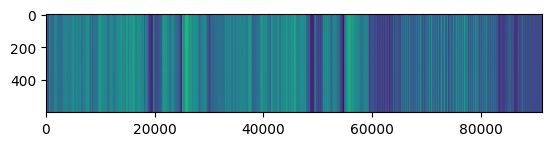

In [13]:
plt.imshow(fsdata, aspect=30)

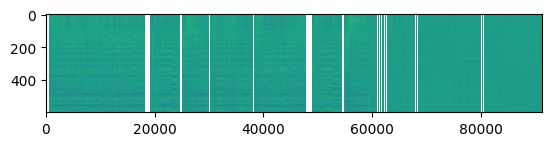

In [12]:
plt.imshow(scipy.stats.zscore(fsdata, axis=0), aspect=30)

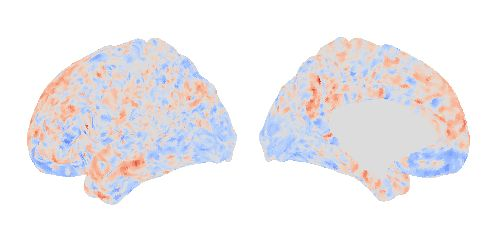

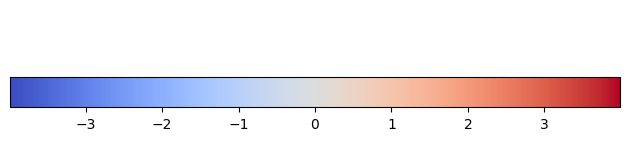

In [108]:
plot_29k(np.nan_to_num(scipy.stats.zscore(fsdata, axis=0))[30, :29696])

In [73]:
def load_cneuro_ts_data(file_path, v=False, bma_slice=slice(0, 29696, None), zscore=False):
  nimg = nib.load(file_path)
  fsdata = nimg.get_fdata()[:, bma_slice]
  if v: print(fsdata.shape)  # (600, 91282), aka we need 8 runs to get to 4800 timepoints
  return scipy.stats.zscore(fsdata, axis=0) if zscore else fsdata

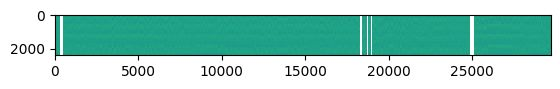

In [87]:
plt.imshow(lh_full_ts)

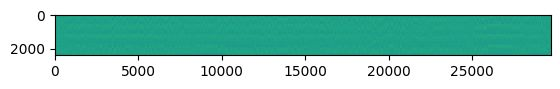

In [92]:
plt.imshow(np.nan_to_num(lh_full_ts))

In [79]:
all_grads_idvpro = {}
expl_vars_indv = np.zeros((len(cneuro_subjs), 200))
indv_pcas =[]

In [122]:
#cneuro_subjs=np.loadtxt("data/subjs_cneuro_xxx").astype(int).astype(str);
group_comps = np.load("data/group_components.pca200c.npy") # hcp reference group components

n_comps = 200
alignment = ProcrustesAlignment(verbose=False, n_iter = 10)

for i, subj in tqdm(enumerate(cneuro_subjs_x), total=len(cneuro_subjs_x)):
  print(subj, end=" ... ")
  if subj in all_grads_idvpro.keys(): continue;

  lh_full_ts = np.concatenate([load_cneuro_ts_data(file, zscore=True, bma_slice= slice(0, 29696, None)) for file in rs_runs[subj][:4]], axis=0)
  
  print(lh_full_ts.shape, end=" ... ")

  icmat = np.nan_to_num(np.corrcoef(lh_full_ts.T))
  print(icmat.shape, end=" ... ")

  pca_indv = PCA(n_components=n_comps)
  indiv_comps = pca_indv.fit_transform(icmat)
  print(indiv_comps.shape, pca_indv.explained_variance_ratio_.sum().round(3))

  indiv_comps_aligned = alignment.fit([indiv_comps], group_comps).aligned_[0]
  #icomps_zgr = pca_zgr.transform(fishers_z(icmat*0.999999999))
  #icomps_gr = pca_gr.transform(icmat)
  
  expl_vars_indv[i,:] = pca_indv.explained_variance_ratio_
  indv_pcas.append(pca_indv)
  

  #icomps = scipy.stats.zscore(icomps, axis=0)
  #all_grads_zgr[subj] = icomps_zgr.astype(np.float32);
  #all_grads_gr[subj] = icomps_gr.astype(np.float32);
  all_grads_idvpro[subj] = indiv_comps_aligned.astype(np.float32);
  clear_output(wait=True)  
    
  
  fn = "/scratch/users/robert.scholz2/acc_dists/all_grads_6_cneuro.L.corrcoef.procrAlignGr.npy"
  np.save(fn, all_grads_idvpro)
  np.save("/scratch/users/robert.scholz2/acc_dists/all_grads_6_cneuro.L.corrcoef.procrAlignGr.pca_info.npy", \
          {"pca_indvs": indv_pcas, "var_expl_ratios" : expl_vars_indv, "subjs":cneuro_subjs[:i+1]});

100%|██████████| 3/3 [04:37<00:00, 92.34s/it] 


In [123]:
np.save("/scratch/users/robert.scholz2/acc_dists/all_grads_6_cneuro.L.corrcoef.procrAlignGr.pca_info.npy", \
          {"pca_indvs": indv_pcas, "var_expl_ratios" : expl_vars_indv, "subjs":cneuro_subjs_x});

In [124]:
!ls -ash /scratch/users/robert.scholz2/acc_dists/all_grads_6_cneuro.L.corrcoef.procrAlignGr.npy

68M /scratch/users/robert.scholz2/acc_dists/all_grads_6_cneuro.L.corrcoef.procrAlignGr.npy


In [117]:
pca_indv.explained_variance_ratio_.sum()

0.9971324504278433

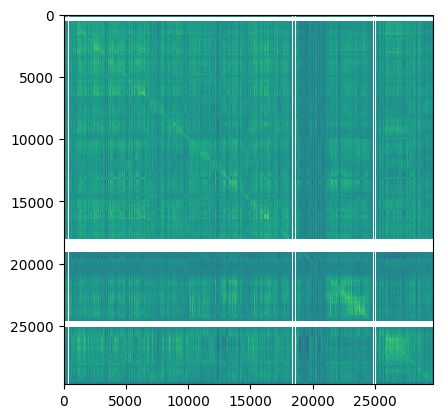

In [95]:
plt.imshow(icmat)

## Preprocess structural maps 

**Convert from maps from fs-native to indiv-fslr32k**

In [ ]:
## Create proper gifti files for the surfaces
#mris_convert "$FreeSurferFolder"/surf/"$hemisphere"h."$Surface" "$T1wFolder"/"$NativeFolder"/"$Subject"."$Hemisphere"."$Surface".native.surf.gii
mris_convert FreeSurferFolder/surf/lh.pial T1wFolder/NativeFolder/sub-001.L.pial.native.surf.gii
mris_convert FreeSurferFolder/surf/lh.white T1wFolder/NativeFolder/sub-001.L.white.native.surf.gii
#wb_command -set-structure "$T1wFolder"/"$NativeFolder"/"$Subject"."$Hemisphere"."$Surface".native.surf.gii ${Structure} -surface-type $Type$Secondary
#wb_command -surface-apply-affine "$T1wFolder"/"$NativeFolder"/"$Subject"."$Hemisphere"."$Surface".native.surf.gii "$FreeSurferFolder"/mri/c_ras.mat "$T1wFolder"/"$NativeFolder"/"$Subject"."$Hemisphere"."$Surface".native.surf.gii
#wb_command -surface-apply-warpfield "$T1wFolder"/"$NativeFolder"/"$Subject"."$Hemisphere"."$Surface".native.surf.gii "$InverseAtlasTransform".nii.gz "$AtlasSpaceFolder"/"$NativeFolder"/"$Subject"."$Hemisphere"."$Surface".native.surf.gii -fnirt "$AtlasTransform".nii.gz

## Create midthickness mesh by averaging white and pial surfaces and use it to make inflated surfacess
# https://github.com/Washington-University/HCPpipelines/blob/master/PostFreeSurfer/scripts/FreeSurfer2CaretConvertAndRegisterNonlinear.sh#L327C5-L327C100
#wb_command -surface-average "$Folder"/"$NativeFolder"/"$Subject"."$Hemisphere".midthickness.native.surf.gii -surf "$Folder"/"$NativeFolder"/"$Subject"."$Hemisphere".white.native.surf.gii -surf "$Folder"/"$NativeFolder"/"$Subject"."$Hemisphere".pial.native.surf.gii
wb_command -surface-average NativeFolder/sub-001.L.midthickness.native.surf.gii 
 -surf NativeFolder/sub-001.L.white.native.surf.gii -surf NativeFolder/sub-001.L.pial.native.surf.gii
#wb_command -set-structure "$Folder"/"$NativeFolder"/"$Subject"."$Hemisphere".midthickness.native.surf.gii ${Structure} -surface-type ANATOMICAL -surface-secondary-type MIDTHICKNESS

## Convert also the microstrcuture maps into proper gifti metric shape files
## so far, everything is still in freesurfer subject-native space
for Map in sulc@sulc@Sulc thickness@thickness@Thickness curv@curvature@Curvature ; do
  fsname, wbname, mapname = Map[1:3]
  #mris_convert -c "$FreeSurferFolder"/surf/"$hemisphere"h."$fsname" "$FreeSurferFolder"/surf/"$hemisphere"h.white "$AtlasSpaceFolder"/"$NativeFolder"/"$Subject"."$Hemisphere"."$wbname".native.shape.gii
  mris_convert -c FreeSurferFolder/surf/lh.sulc FreeSurferFolder/surf/lh.white NativeFolder/sub-001.L.sulc.native.shape.gii
  #wb_command -set-structure "$AtlasSpaceFolder"/"$NativeFolder"/"$Subject"."$Hemisphere"."$wbname".native.shape.gii ${Structure}
  
  # inverse the map?
  # wb_command -metric-math "var * -1" "$AtlasSpaceFolder"/"$NativeFolder"/"$Subject"."$Hemisphere"."$wbname".native.shape.gii -var var "$AtlasSpaceFolder"/"$NativeFolder"/"$Subject"."$Hemisphere"."$wbname".native.shape.gii
  wb_command -metric-math "var * -1" NativeFolder/sub-001.L.sulc.native.shape.gii -var var NativeFolder/sub-001.L.sulc.native.shape.gii
  #wb_command -set-map-names "$AtlasSpaceFolder"/"$NativeFolder"/"$Subject"."$Hemisphere"."$wbname".native.shape.gii -map 1 "$Subject"_"$Hemisphere"_"$mapname"
  #wb_command -metric-palette "$AtlasSpaceFolder"/"$NativeFolder"/"$Subject"."$Hemisphere"."$wbname".native.shape.gii MODE_AUTO_SCALE_PERCENTAGE -pos-percent 2 98 -palette-name Gray_Interp -disp-pos true -disp-neg true -disp-zero true

## Do the actual resampling from native to fslr32k space
# for that we need the registered spheres ...
RegSphere= AtlasSpaceFolder/NativeFolder/sub-001.L.sphere.MSMSulc.native.surf.gii
# nativefolder is always in the atlasspacefolder

wb_command -metric-resample NativeFolder/sub-001.L.sulc.native.shape.gii $RegSphere 
  AtlasSpaceFolder/fsaverage_LR32k/sub-001.L.sphere.32k_fs_LR.surf.gii 
  ADAP_BARY_AREA 
  AtlasSpaceFolder/fsaverage_LR32k/sub-001.L.sulc.32k_fs_LR.shape.gii 
  -area-surfs T1W/NativeFolder/sub-001.L.midthickness.native.surf.gii
  AtlasSpaceFolder/fsaverage_LR32k/sub-001.L.midthickness.32k_fs_LR.surf.gii 
  -current-roi AtlasSpaceFolder/NativeFolder/sub-001.L.roi.native.shape.gii



In [ ]:
## Minimal sample 

mris_convert -c anat.freesurfer/sub-01/surf/lh.sulc anat.freesurfer/sub-01/surf/sub-001.L.sulc.native.shape.gii
mris_convert FreeSurferFolder/surf/lh.sphere.reg anat.freesurfer/sub-01/surf/sub-001.L.sphere.reg.native.surf.gii

$RegSphere=anat.freesurfer/sub-01/surf/sub-001.L.sphere.reg.native.surf.gii
$FS32kSphere= fsaverage_LR32k/sub-001.L.sulc.32k_fs_LR.shape.gii 
wb_command -metric-resample anat.freesurfer/sub-01/surf/sub-001.L.sulc.native.shape.gii $RegSphere $FS32kSphere ADAP_BARY_AREA
  output/sub-001.L.sulc.32k_fs_LR.shape.gii 

## Compute task maps (prediction targets)

### Sample First Level Analysis

**Load event and mri-run files**

In [198]:
# event dataframe probably only needs "trial_type", "onset" and "duration"
events_raw = pd.read_table(event_files[0])
print(np.unique(events_raw["trial_type"]))
events = events_raw[["trial_type", "onset", "duration"]]
events[:3]

['presentation_math' 'presentation_story' 'question_math' 'question_story'
 'response_math' 'response_story']


,trial_type,onset,duration
0,presentation_story,0.300,18.834
1,question_story,19.647,4.281
2,response_story,23.947,0.998


In [199]:
events_raw

,trial_type,stim_file,ntrial,onset,duration,stim_file_question1,stim_file_question2,question_option1,question_option2,onset_that_was_about,onset_question_option1,onset_or,onset_question_option2,correct_answer,answer,response_time
0,presentation_story,language/story/Story22.wav,1.0,0.300,18.834,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1,question_story,NaN,1.0,19.647,4.281,language/story/taking.wav,language/story/looking.wav,taking,looking,19.647,20.964,21.730,23.113,NaN,NaN,NaN
2,response_story,NaN,1.0,23.947,0.998,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,option1,option1,0.998
3,presentation_math,language/math/math-level10-130-Q.wav,2.0,28.396,5.601,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
4,question_math,NaN,2.0,34.213,3.683,language/math/math-level10-130-1.wav,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
5,response_math,NaN,2.0,37.912,2.984,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,option1,option1,2.984
6,presentation_math,language/math/math-level10-16-Q.wav,3.0,41.062,5.485,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
7,question_math,NaN,3.0,46.812,3.385,language/math/math-level10-16-2.wav,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
8,response_math,NaN,3.0,50.212,2.985,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,option2,option2,2.985
9,presentation_math,language/math/math-level10-30-Q.wav,4.0,53.412,5.964,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN


In [11]:
# not sure if I should be doing smoothing too
run = nib.load(cifti_files[0])
print(run.shape)
plot_29k(run.get_fdata()[100, :29696])

(159, 91282)

**Create design matrix and run GLM**

In [32]:
tr = 1.49
n_scans = run.shape[0]
frame_times = 0.1175 + np.arange(n_scans) * tr
frame_times.round(2)[:5], (frame_times[-1]/60).round(2), "min"


(array([0.12, 1.61, 3.1 , 4.59, 6.08]), 3.93, 'min')

<AxesSubplot:label='conditions', ylabel='scan number'>

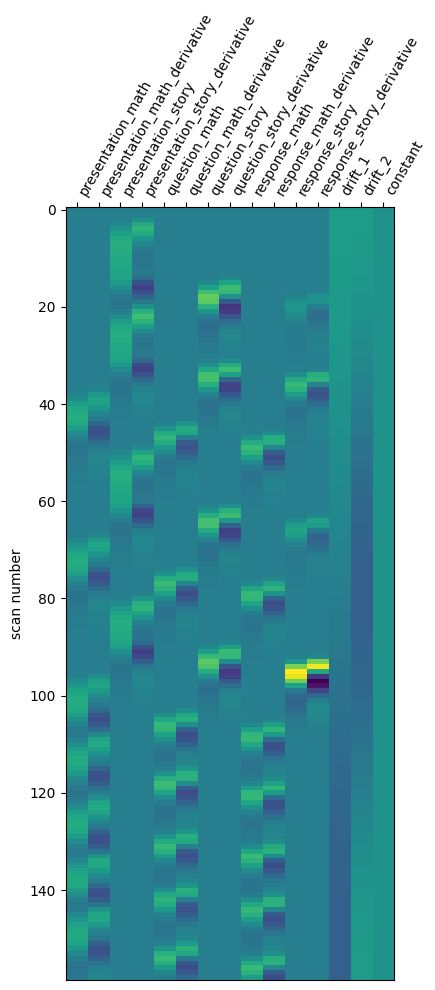

In [151]:
# Surface-based autocorrelation estimate smoothing was incorporated into FSL’s FILM at a sigma of 5mm

# using pretty much the defaults, except for "spm + derivative", as "glover" is default
design_matrix = make_first_level_design_matrix(frame_times, events, hrf_model= "glover + derivative",
  drift_model="Cosine",high_pass= 0.005) #, slice_time_ref = 0.0, high_pass=0.01 default; 200s highpass for hcp

from nilearn.plotting import plot_design_matrix
plot_design_matrix(design_matrix)

In [152]:
#from nilearn.glm.first_level import FirstLevelModel
print("Fitting a GLM")
#fmri_glm = FirstLevelModel()
# fmri_glm = FirstLevelModel(mask_img=data['mask'], minimize_memory=True)
#fmri_glm = fmri_glm.fit(run.get_fdata(), design_matrices=[design_matrix])

labels, estimates = run_glm(run.get_fdata(), design_matrix.values)

Fitting a GLM


**Define and estimate contrasts**

dict_keys(['presentation_math', 'presentation_math_derivative', 'presentation_story', 'presentation_story_derivative', 'question_math', 'question_math_derivative', 'question_story', 'question_story_derivative', 'response_math', 'response_math_derivative', 'response_story', 'response_story_derivative', 'drift_1', 'drift_2', 'constant'])


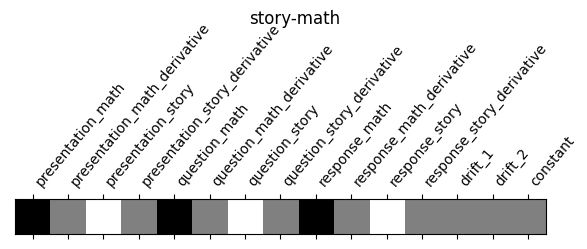

In [153]:
contrast_matrix = np.eye(design_matrix.shape[1])
bc = {  column: contrast_matrix[i] for i, column in enumerate(design_matrix.columns) }
print(bc.keys())

bc["story"] = bc['presentation_story'] + bc['question_story'] + bc['response_story']
bc["math"] = bc['presentation_math'] + bc['question_math'] + bc['response_math']

contrasts = {
    "story-math": bc["story"] - bc["math"],
}

from nilearn.plotting import plot_contrast_matrix
for key, values in contrasts.items():
    plot_contrast_matrix(values, design_matrix=design_matrix)
    plt.suptitle(key)

	contrast id: story-math
(91282,)


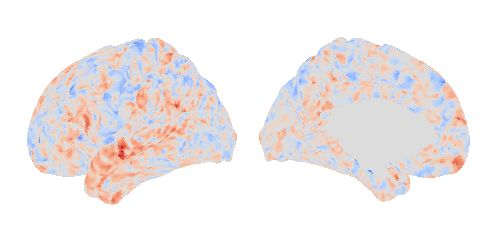

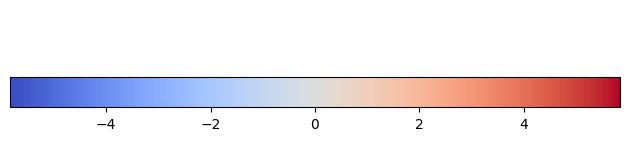

In [78]:
for contrast_id, contrast_val in contrasts.items():
  print(f"\tcontrast id: {contrast_id}")
  # compute the contrasts
  contrast = compute_contrast(labels, estimates, contrast_val, contrast_type='t')
  z_score = contrast.z_score()
  x_score = contrast.stat()
  print(z_score.shape)
  plot_29k(x_score[:29696])  
  #plot_29k(z_score[:29696])

**compare with reference contrasts**

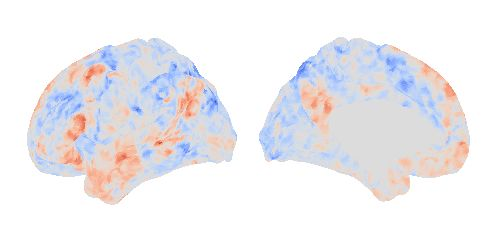

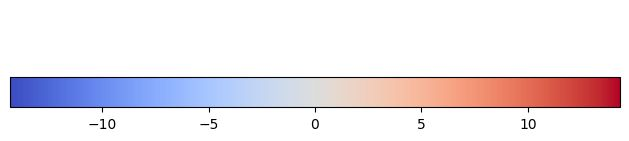

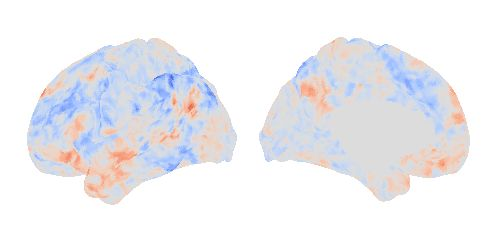

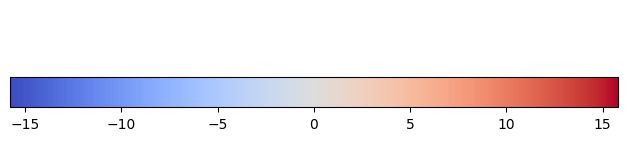

In [82]:
fn = "/scratch/users/robert.scholz2/acc_dists/all_10_tasks_254_full_unrelated.raw.npy"
yfull_task_data =np.load(fn, allow_pickle=True).item()
print(yfull_task_data["208327"].shape)
plot_29k(yfull_task_data["208327"][:,6])
plot_29k(yfull_task_data["525541"][:,6])

### Multi-Run task contrast analysis


In [14]:
from nilearn.glm.contrasts import _compute_fixed_effect_contrast

In [15]:
# multiple runs:

def estimate_mutli_run_first_level(cifti_files, event_files, verbose=False, tr=None):
 #n_runs= len(cifti_files)#4
 labels_ = []; results_ = []; design_mats = []

 for run_idx, run_file in enumerate(cifti_files):
   events = pd.read_table(event_files[run_idx])[["trial_type", "onset", "duration"]]
   #frame_times = 0.1175 + np.arange(n_scans) * tr
   run_data = nib.load(run_file).get_fdata();
   if verbose: print(f"Run#{run_idx} {run_data.shape}, n_events={len(events)}, "+ \
         f"file: {event_files[run_idx].split('/')[-1]}")
   n_scans = run_data.shape[0]
   if tr is None:
        tr = nib.load(run_file).header.get_axis(0).step;
   frame_times = np.arange(n_scans) * tr
   design_matrix = make_first_level_design_matrix(\
      frame_times, events, hrf_model= "glover + derivative", drift_model="Cosine",high_pass= 0.005)
   design_mats.append(design_matrix)
   
   labels, results = run_glm(run_data, design_matrix.values)
   labels_.append(labels)
   results_.append(results)

 # make sure all the runs have the same events
 for dmat in design_mats[1:]:
   assert dmat.columns.tolist() == design_mats[0].columns.tolist()

 return labels_, results_, design_mats;

def compute_contrast_from_multi_first_level(labels_, results_, contrast_defs):
  contrasts = []
  n_runs = len(labels_)
  for contrast_id, contrast_val in contrast_defs.items():
   contrast = _compute_fixed_effect_contrast(labels_, results_, [contrast_val]*n_runs, contrast_type='t')
   contrasts.append(contrast)
  return contrasts

**single subject lanugage example**

In [16]:
subj = "sub-01"
task= "LANGUAGE"
cifti_files = runs[subj][task]
event_files = events[subj][task]

In [ ]:
labels_, results_, design_mats = estimate_mutli_run_first_level(cifti_files[:1], event_files[:1], verbose=0, tr=1.49)
contrast_matrix = np.eye(design_mats[0].shape[1])
bc = {  column: contrast_matrix[i] for i, column in enumerate(design_mats[0].columns) }
bc["story"] = bc['presentation_story'] + bc['question_story'] + bc['response_story']
bc["math"] = bc['presentation_math'] + bc['question_math'] + bc['response_math']
contrast_defs = {"story-math": bc["story"] - bc["math"]}

In [65]:
labels_, results_, design_mats = estimate_mutli_run_first_level(cifti_files[:1], event_files[:1], verbose=0, tr=1.49)
contrast_matrix = np.eye(design_mats[0].shape[1])
bc = {  column: contrast_matrix[i] for i, column in enumerate(design_mats[0].columns) }
contrast_defs = {"story-math": bc["presentation_story"] - bc["presentation_math"]}

Run#0 (159, 91282), n_events=42, file: sub-01_ses-002_task-language_run-01_events.tsv
Run#1 (159, 91282), n_events=36, file: sub-01_ses-003_task-language_run-01_events.tsv
Run#2 (159, 91282), n_events=33, file: sub-01_ses-005_task-language_run-01_events.tsv
Run#3 (159, 91282), n_events=30, file: sub-01_ses-006_task-language_run-01_events.tsv
(91282,)


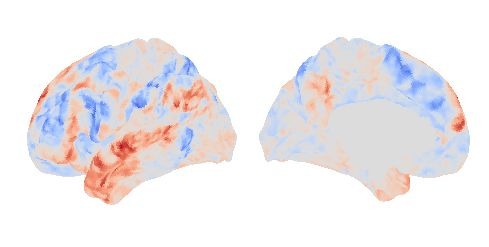

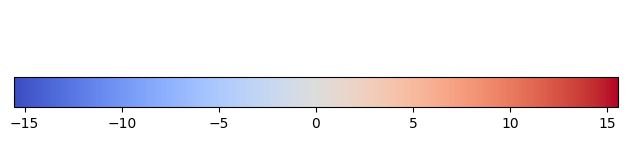

In [66]:
labels_, results_, design_mats = estimate_mutli_run_first_level(cifti_files[:8:2], event_files[:8:2], verbose=1)
contrasts = compute_contrast_from_multi_first_level(labels_, results_, contrast_defs)
a_score = contrasts[0].stat()
print(a_score.shape) 
plot_29k(a_score[:29696]) 

Run#0 (159, 91282), n_events=36, file: sub-01_ses-002_task-language_run-02_events.tsv
Run#1 (159, 91282), n_events=33, file: sub-01_ses-004_task-language_run-01_events.tsv
Run#2 (159, 91282), n_events=30, file: sub-01_ses-005_task-language_run-02_events.tsv
Run#3 (159, 91282), n_events=33, file: sub-01_ses-006_task-language_run-02_events.tsv


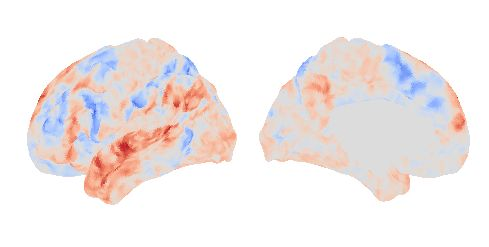

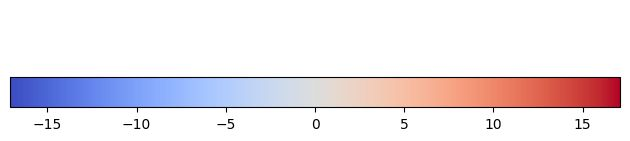

In [68]:
labels_, results_, design_mats = estimate_mutli_run_first_level(cifti_files[1:8:2], event_files[1:8:2], verbose=1)
contrasts = compute_contrast_from_multi_first_level(labels_, results_, contrast_defs)
b_score = contrasts[0].stat()
plot_29k(b_score[:29696]) 

In [69]:
np.corrcoef(a_score[:29696], b_score[:29696])

array([[1.        , 0.92333952],
       [0.92333952, 1.        ]])

### > All Task multirun

In [64]:
# List all the available events first level columns
for subj in cneuro_subjs[:1]:
  for task in tasks:
    labels_, results_, design_mats = estimate_mutli_run_first_level(runs[subj][task][:1], events[subj][task][:1], verbose=0)
    contrast_matrix = np.eye(design_mats[0].shape[1])
    bc = {  column: contrast_matrix[i] for i, column in enumerate(design_mats[0].columns) }
    print("\n", subj, task, bc.keys())
    


 sub-01: 
 sub-01 EMOTION dict_keys(['countdown', 'countdown_derivative', 'new_bloc_face', 'new_bloc_face_derivative', 'new_bloc_shape', 'new_bloc_shape_derivative', 'response_face', 'response_face_derivative', 'response_shape', 'response_shape_derivative', 'drift_1', 'constant'])

 sub-01 GAMBLING dict_keys(['Feedback', 'Feedback_derivative', 'Neutral', 'Neutral_derivative', 'Punishment', 'Punishment_derivative', 'Reward', 'Reward_derivative', 'countdown', 'countdown_derivative', 'drift_1', 'constant'])

 sub-01 LANGUAGE dict_keys(['presentation_math', 'presentation_math_derivative', 'presentation_story', 'presentation_story_derivative', 'question_math', 'question_math_derivative', 'question_story', 'question_story_derivative', 'response_math', 'response_math_derivative', 'response_story', 'response_story_derivative', 'drift_1', 'drift_2', 'constant'])

 sub-01 MOTOR dict_keys(['countdown', 'countdown_derivative', 'cross_fixation', 'cross_fixation_derivative', 'new_bloc_left_foot', '

/usr/users/robert.scholz2/.local/lib/python3.9/site-packages/nilearn/glm/first_level/experimental_paradigm.py:117: UserWarning: Duplicated events were detected. Amplitudes of these events will be summed. You might want to verify your inputs.
  warnings.warn("Duplicated events were detected. "



 sub-01 WM dict_keys(['0-Back', '0-Back_derivative', '2-Back', '2-Back_derivative', 'countdown', 'countdown_derivative', 'drift_1', 'drift_2', 'drift_3', 'constant'])


In [44]:
# print(unique_contrasts[contrast_ids_to_show])
# ['LANGUAGE_STORY-MATH' 'WM_2BK-0BK' 'MOTOR_CUE-AVG' 'EMOTION_FACES-SHAPES' 'SOCIAL_TOM-RANDOM' 'RELATIONAL_REL-MATCH' 'GAMBLING_REWARD-PUNISH' 'WM_FACE-AVG' 'MOTOR_T-AVG']

def get_contrast_defs_for_task(design_mats, task):
    contrast_defs = {}
    task=task.upper();
    
    contrast_matrix = np.eye(design_mats[0].shape[1])
    bc = {  column: contrast_matrix[i] for i, column in enumerate(design_mats[0].columns) }
    
    if task == 'LANGUAGE':
      contrast_defs = {"LANGUAGE_STORY-MATH": bc["presentation_story"] - bc["presentation_math"]}
    
    if task == 'WM':
      """bc["face"] =  ????
      bc["avg"] =   ????
      contrast_defs = {"WM_FACE-AVG": bc["face"] - bc["avg"]}"""
      contrast_defs = {"WM_2BK-0BK": bc["2-Back"] - bc["0-Back"]}
    
    """if task == 'MOTOR':
      ### ??????????????????????????????
      bc["avg"] =   ????
      bc["t"] =   ????
      contrast_defs = {"MOTOR_CUE-AVG": bc["cross_fixation"] -bc["avg"]  }
      contrast_defs.update({"MOTOR_T-AVG": bc["t"]-  bc["avg"] })"""
    
    if task == 'EMOTION':
      contrast_defs = {"EMOTION_FACES-SHAPES": bc["response_face"] - bc["response_shape"]}
    
    if task == 'SOCIAL':
      contrast_defs = {"SOCIAL_TOM-RANDOM": bc["mental"] - bc["random"]}
    
    if task == 'RELATIONAL':
      contrast_defs = {"RELATIONAL_REL-MATCH": bc["Relational"] - bc["Control"]}
    
    if task == 'GAMBLING':
      contrast_defs = {"GAMBLING_REWARD-PUNISH": bc["Reward"] - bc["Punishment"]}
    
    return contrast_defs;

In [77]:
task_contrasts = defaultdict(mydefault)
retest_contrasts = defaultdict(mydefault)

for subj in cneuro_subjs_x:
  print(subj, end=": ");
  for task in tasks:
    if task in ["MOTOR"]: continue; # not implemented
    
    #for trt, slc in enumerate([slice(0,4),slice(4, None)]):
    for trt, slc in enumerate([slice(0,8,2),slice(1,8,2)]):
        labels_, results_, design_mats = estimate_mutli_run_first_level(runs[subj][task][:4], events[subj][task][:4], verbose=0)
        contrast_defs= get_contrast_defs_for_task(design_mats, task)
        contrasts = compute_contrast_from_multi_first_level(labels_, results_, contrast_defs)
        print(task, len(contrasts), contrasts[0].contrast_type, ("test" if trt==0 else "retest"), end =", ")
        
        for i in range(len(contrasts)):
           cname= list(contrast_defs.keys())[i]
           if trt ==0:
             task_contrasts[subj][cname] = contrasts[0].stat();
           else: 
             retest_contrasts[subj][cname] = contrasts[0].stat();
                
#https://github.com/nilearn/nilearn/blob/4f4730163097457cf9ddb5674ffd158ee8fa822e/nilearn/glm/first_level/experimental_paradigm.py#L199

sub-01: EMOTION 1 t test, EMOTION 1 t retest, 

/usr/users/robert.scholz2/.local/lib/python3.9/site-packages/nilearn/glm/first_level/experimental_paradigm.py:117: UserWarning: Duplicated events were detected. Amplitudes of these events will be summed. You might want to verify your inputs.
  warnings.warn("Duplicated events were detected. "
/usr/users/robert.scholz2/.local/lib/python3.9/site-packages/nilearn/glm/first_level/hemodynamic_models.py:299: UserWarning: Some stimulus onsets are earlier than -24.0 in the experiment and are thus not considered in the model
  warnings.warn(('Some stimulus onsets are earlier than %s in the'
/usr/users/robert.scholz2/.local/lib/python3.9/site-packages/nilearn/glm/first_level/experimental_paradigm.py:117: UserWarning: Duplicated events were detected. Amplitudes of these events will be summed. You might want to verify your inputs.
  warnings.warn("Duplicated events were detected. "


GAMBLING 1 t test, 

/usr/users/robert.scholz2/.local/lib/python3.9/site-packages/nilearn/glm/first_level/experimental_paradigm.py:117: UserWarning: Duplicated events were detected. Amplitudes of these events will be summed. You might want to verify your inputs.
  warnings.warn("Duplicated events were detected. "
/usr/users/robert.scholz2/.local/lib/python3.9/site-packages/nilearn/glm/first_level/hemodynamic_models.py:299: UserWarning: Some stimulus onsets are earlier than -24.0 in the experiment and are thus not considered in the model
  warnings.warn(('Some stimulus onsets are earlier than %s in the'
/usr/users/robert.scholz2/.local/lib/python3.9/site-packages/nilearn/glm/first_level/experimental_paradigm.py:117: UserWarning: Duplicated events were detected. Amplitudes of these events will be summed. You might want to verify your inputs.
  warnings.warn("Duplicated events were detected. "


GAMBLING 1 t retest, LANGUAGE 1 t test, LANGUAGE 1 t retest, RELATIONAL 1 t test, RELATIONAL 1 t retest, SOCIAL 1 t test, SOCIAL 1 t retest, 

/usr/users/robert.scholz2/.local/lib/python3.9/site-packages/nilearn/glm/first_level/experimental_paradigm.py:117: UserWarning: Duplicated events were detected. Amplitudes of these events will be summed. You might want to verify your inputs.
  warnings.warn("Duplicated events were detected. "
/usr/users/robert.scholz2/.local/lib/python3.9/site-packages/nilearn/glm/first_level/experimental_paradigm.py:117: UserWarning: Duplicated events were detected. Amplitudes of these events will be summed. You might want to verify your inputs.
  warnings.warn("Duplicated events were detected. "
/usr/users/robert.scholz2/.local/lib/python3.9/site-packages/nilearn/glm/first_level/experimental_paradigm.py:117: UserWarning: Duplicated events were detected. Amplitudes of these events will be summed. You might want to verify your inputs.
  warnings.warn("Duplicated events were detected. "
/usr/users/robert.scholz2/.local/lib/python3.9/site-packages/nilearn/glm/first_level/experimental_paradigm.py:117: Use

WM 1 t test, 

/usr/users/robert.scholz2/.local/lib/python3.9/site-packages/nilearn/glm/first_level/experimental_paradigm.py:117: UserWarning: Duplicated events were detected. Amplitudes of these events will be summed. You might want to verify your inputs.
  warnings.warn("Duplicated events were detected. "
/usr/users/robert.scholz2/.local/lib/python3.9/site-packages/nilearn/glm/first_level/experimental_paradigm.py:117: UserWarning: Duplicated events were detected. Amplitudes of these events will be summed. You might want to verify your inputs.
  warnings.warn("Duplicated events were detected. "
/usr/users/robert.scholz2/.local/lib/python3.9/site-packages/nilearn/glm/first_level/experimental_paradigm.py:117: UserWarning: Duplicated events were detected. Amplitudes of these events will be summed. You might want to verify your inputs.
  warnings.warn("Duplicated events were detected. "
/usr/users/robert.scholz2/.local/lib/python3.9/site-packages/nilearn/glm/first_level/experimental_paradigm.py:117: Use

WM 1 t retest, sub-03: EMOTION 1 t test, EMOTION 1 t retest, 

/usr/users/robert.scholz2/.local/lib/python3.9/site-packages/nilearn/glm/first_level/hemodynamic_models.py:299: UserWarning: Some stimulus onsets are earlier than -24.0 in the experiment and are thus not considered in the model
  warnings.warn(('Some stimulus onsets are earlier than %s in the'


GAMBLING 1 t test, 

/usr/users/robert.scholz2/.local/lib/python3.9/site-packages/nilearn/glm/first_level/hemodynamic_models.py:299: UserWarning: Some stimulus onsets are earlier than -24.0 in the experiment and are thus not considered in the model
  warnings.warn(('Some stimulus onsets are earlier than %s in the'


GAMBLING 1 t retest, LANGUAGE 1 t test, LANGUAGE 1 t retest, RELATIONAL 1 t test, RELATIONAL 1 t retest, SOCIAL 1 t test, SOCIAL 1 t retest, 

/usr/users/robert.scholz2/.local/lib/python3.9/site-packages/nilearn/glm/first_level/experimental_paradigm.py:117: UserWarning: Duplicated events were detected. Amplitudes of these events will be summed. You might want to verify your inputs.
  warnings.warn("Duplicated events were detected. "
/usr/users/robert.scholz2/.local/lib/python3.9/site-packages/nilearn/glm/first_level/experimental_paradigm.py:117: UserWarning: Duplicated events were detected. Amplitudes of these events will be summed. You might want to verify your inputs.
  warnings.warn("Duplicated events were detected. "
/usr/users/robert.scholz2/.local/lib/python3.9/site-packages/nilearn/glm/first_level/experimental_paradigm.py:117: UserWarning: Duplicated events were detected. Amplitudes of these events will be summed. You might want to verify your inputs.
  warnings.warn("Duplicated events were detected. "
/usr/users/robert.scholz2/.local/lib/python3.9/site-packages/nilearn/glm/first_level/experimental_paradigm.py:117: Use

WM 1 t test, 

/usr/users/robert.scholz2/.local/lib/python3.9/site-packages/nilearn/glm/first_level/experimental_paradigm.py:117: UserWarning: Duplicated events were detected. Amplitudes of these events will be summed. You might want to verify your inputs.
  warnings.warn("Duplicated events were detected. "
/usr/users/robert.scholz2/.local/lib/python3.9/site-packages/nilearn/glm/first_level/experimental_paradigm.py:117: UserWarning: Duplicated events were detected. Amplitudes of these events will be summed. You might want to verify your inputs.
  warnings.warn("Duplicated events were detected. "
/usr/users/robert.scholz2/.local/lib/python3.9/site-packages/nilearn/glm/first_level/experimental_paradigm.py:117: UserWarning: Duplicated events were detected. Amplitudes of these events will be summed. You might want to verify your inputs.
  warnings.warn("Duplicated events were detected. "
/usr/users/robert.scholz2/.local/lib/python3.9/site-packages/nilearn/glm/first_level/experimental_paradigm.py:117: Use

WM 1 t retest, sub-05: EMOTION 1 t test, EMOTION 1 t retest, 

/usr/users/robert.scholz2/.local/lib/python3.9/site-packages/nilearn/glm/first_level/experimental_paradigm.py:117: UserWarning: Duplicated events were detected. Amplitudes of these events will be summed. You might want to verify your inputs.
  warnings.warn("Duplicated events were detected. "
/usr/users/robert.scholz2/.local/lib/python3.9/site-packages/nilearn/glm/first_level/experimental_paradigm.py:117: UserWarning: Duplicated events were detected. Amplitudes of these events will be summed. You might want to verify your inputs.
  warnings.warn("Duplicated events were detected. "
/usr/users/robert.scholz2/.local/lib/python3.9/site-packages/nilearn/glm/first_level/hemodynamic_models.py:299: UserWarning: Some stimulus onsets are earlier than -24.0 in the experiment and are thus not considered in the model
  warnings.warn(('Some stimulus onsets are earlier than %s in the'


GAMBLING 1 t test, 

/usr/users/robert.scholz2/.local/lib/python3.9/site-packages/nilearn/glm/first_level/experimental_paradigm.py:117: UserWarning: Duplicated events were detected. Amplitudes of these events will be summed. You might want to verify your inputs.
  warnings.warn("Duplicated events were detected. "
/usr/users/robert.scholz2/.local/lib/python3.9/site-packages/nilearn/glm/first_level/experimental_paradigm.py:117: UserWarning: Duplicated events were detected. Amplitudes of these events will be summed. You might want to verify your inputs.
  warnings.warn("Duplicated events were detected. "
/usr/users/robert.scholz2/.local/lib/python3.9/site-packages/nilearn/glm/first_level/hemodynamic_models.py:299: UserWarning: Some stimulus onsets are earlier than -24.0 in the experiment and are thus not considered in the model
  warnings.warn(('Some stimulus onsets are earlier than %s in the'


GAMBLING 1 t retest, LANGUAGE 1 t test, LANGUAGE 1 t retest, RELATIONAL 1 t test, RELATIONAL 1 t retest, SOCIAL 1 t test, SOCIAL 1 t retest, 

/usr/users/robert.scholz2/.local/lib/python3.9/site-packages/nilearn/glm/first_level/experimental_paradigm.py:117: UserWarning: Duplicated events were detected. Amplitudes of these events will be summed. You might want to verify your inputs.
  warnings.warn("Duplicated events were detected. "
/usr/users/robert.scholz2/.local/lib/python3.9/site-packages/nilearn/glm/first_level/experimental_paradigm.py:117: UserWarning: Duplicated events were detected. Amplitudes of these events will be summed. You might want to verify your inputs.
  warnings.warn("Duplicated events were detected. "
/usr/users/robert.scholz2/.local/lib/python3.9/site-packages/nilearn/glm/first_level/experimental_paradigm.py:117: UserWarning: Duplicated events were detected. Amplitudes of these events will be summed. You might want to verify your inputs.
  warnings.warn("Duplicated events were detected. "
/usr/users/robert.scholz2/.local/lib/python3.9/site-packages/nilearn/glm/first_level/experimental_paradigm.py:117: Use

WM 1 t test, 

/usr/users/robert.scholz2/.local/lib/python3.9/site-packages/nilearn/glm/first_level/experimental_paradigm.py:117: UserWarning: Duplicated events were detected. Amplitudes of these events will be summed. You might want to verify your inputs.
  warnings.warn("Duplicated events were detected. "
/usr/users/robert.scholz2/.local/lib/python3.9/site-packages/nilearn/glm/first_level/experimental_paradigm.py:117: UserWarning: Duplicated events were detected. Amplitudes of these events will be summed. You might want to verify your inputs.
  warnings.warn("Duplicated events were detected. "
/usr/users/robert.scholz2/.local/lib/python3.9/site-packages/nilearn/glm/first_level/experimental_paradigm.py:117: UserWarning: Duplicated events were detected. Amplitudes of these events will be summed. You might want to verify your inputs.
  warnings.warn("Duplicated events were detected. "
/usr/users/robert.scholz2/.local/lib/python3.9/site-packages/nilearn/glm/first_level/experimental_paradigm.py:117: Use

WM 1 t retest, 

In [78]:
p = dict(task_contrasts=task_contrasts, retest_contrasts=retest_contrasts, trt_slices=[slice(0,8,2),slice(1,8,2)], \
         events=events, runs=runs, subjs=cneuro_subjs_x)
np.save("data/cneuromod_task_contrasts_3subjs.npy",p)
!ls -ash data/cneuromod_task_contrasts_3subjs.npy

26M data/cneuromod_task_contrasts_3subjs.npy


In [46]:
task_contrasts['sub-01'].keys()

dict_keys(['EMOTION_FACES-SHAPES', 'GAMBLING_REWARD-PUNISH', 'LANGUAGE_STORY-MATH', 'RELATIONAL_REL-MATCH', 'SOCIAL_TOM-RANDOM', 'WM_2BK-0BK'])

### Comparison with task contrasts from HCP

In [48]:
fn = "/scratch/users/robert.scholz2/dist_model/results/retest_hcp40.task_maps47.zscored.npy"
payload = np.load(fn, allow_pickle=1).item()
tdata = payload["test_data"] #rdata = payload["retest_data"]
mean_test_maps = tdata.mean(axis=0); 

In [57]:
transform = {"img1": hcp.left_cortex_data, "img2": hcp.left_cortex_data, "img3": hcp.left_cortex_data}
pcf = ["img1_0_180_6.4", "img2_0_180_6.4", "img3_0_180_6.4"]
stub = '/usr/users/robert.scholz2/.local/lib/python3.9/site-packages/brainspace/datasets/surfaces/'
surfs = [stub+"conte69_32k_lh.gii"]*3

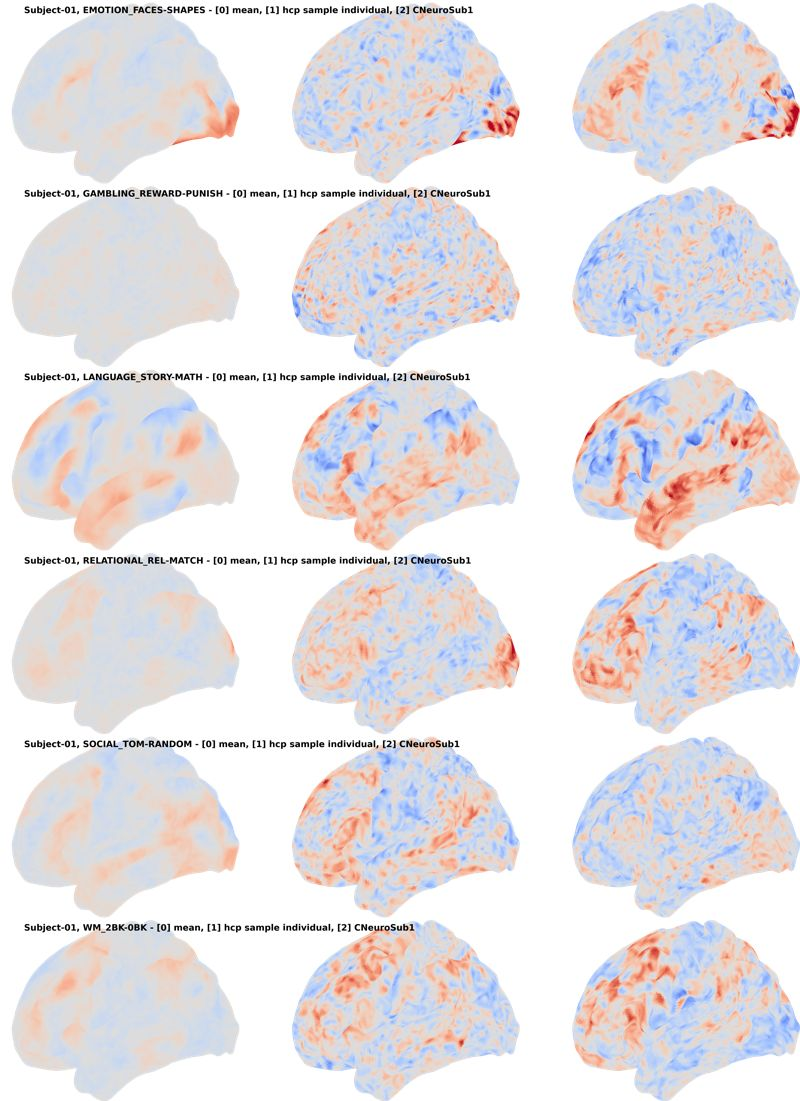

In [69]:
from lib.plotting import plot_gen_surf2, image_grid, fig2tightPIL

v = np.absolute(mean_test_maps).max()
full_retest_imgs=[]

for contrast_name in task_contrasts['sub-01'].keys():
  tn = list(unique_contrasts).index(contrast_name)
  data0 = mean_test_maps[:,tn]
  data1 = tdata[0,:, tn]
  data2 = scipy.stats.zscore(task_contrasts['sub-01'][contrast_name])
  plot_gen_surf2([data0, data1, data2], transform=transform, surfs=surfs, plot_conf=pcf, vmin=-v, vmax=v, cmap='coolwarm');
  plt.gcf().suptitle(f"Subject-01, {unique_contrasts[tn]} - [0] mean, [1] hcp sample individual, [2] CNeuroSub1", x=0.06, y=0.82, ha='left', va='top', weight='bold', size=14)
  pil_img = fig2tightPIL(close_fig=1, dpi=300)
  full_retest_imgs.append(pil_img)
  #display(pil_img)

rtst2subjimg=image_grid(full_retest_imgs, len(task_contrasts['sub-01'].keys()),1, pad=0.015)
#rtst2subjimg.save("retest_lang_examples.png")
rtst2subjimg

In [65]:
cneuro_subjs

array(['sub-01', 'sub-02', 'sub-03', 'sub-04', 'sub-05', 'sub-06'],
      dtype='<U6')

# Model fitting

In [16]:
import sys
sys.path.append("/home/mpg02/MLSC/robert.scholz2/.local/lib/python3.7/site-packages")
from sklearn.utils import Bunch
import scipy
from lib.linear_models import score
import sklearn
from lib.linear_models import train_test_split
from lib.data_loading import load_xy_data

## loading the data

In [39]:
# Prediction targets

p = np.load("data/cneuromod_task_contrasts_3subjs.npy", allow_pickle=1).item()
p.keys()
task_contrasts = p["task_contrasts"]
subjs = p["subjs"]
subj=subjs[0]

cneuromod_contrasts = list(task_contrasts[subjs[0]].keys())
# reorder
cneuromod_task_names = ["Language", "Emotion", "WM", "Social", "Relational", "Gambling"]

cneuromod_contrasts = ['LANGUAGE_STORY-MATH', 'EMOTION_FACES-SHAPES', 'WM_2BK-0BK', 'SOCIAL_TOM-RANDOM', 'RELATIONAL_REL-MATCH','GAMBLING_REWARD-PUNISH',]
z_score_predictors_along_dim = 1# 1 ~ along spatial axis; 0~ across subjects


print(f"Subjects n={len(subjs)}:", subjs[:5])
print(f"Contrasts n={len(cneuromod_contrasts)}:", cneuromod_contrasts)

Subjects n=3: ['sub-01', 'sub-03', 'sub-05']
Contrasts n=6: ['LANGUAGE_STORY-MATH', 'EMOTION_FACES-SHAPES', 'WM_2BK-0BK', 'SOCIAL_TOM-RANDOM', 'RELATIONAL_REL-MATCH', 'GAMBLING_REWARD-PUNISH']


In [29]:
# Predictors (RS-PCA)
fn = "/scratch/users/robert.scholz2/acc_dists/all_grads_6_cneuro.L.corrcoef.procrAlignGr.npy"
predictors = np.load(fn, allow_pickle=1).item()
predictors = {subj : predictors[subj] for subj in subjs}
print("Predictors:\t", len(predictors), predictors[subj].shape)
yfull_task_data = {subj : np.array( [task_contrasts[subj][contr][:29696] for contr in cneuromod_contrasts]).T for subj in subjs}
print("Targets:\t", len(yfull_task_data), yfull_task_data[subj].shape)


Predictors:	 3 (29696, 200)
Targets:	 3 (29696, 6)


In [30]:
# Preprocessing

isubjs, xdata, ydata = load_xy_data(subjs, "", predictors, yfull_task_data)
if not(z_score_predictors_along_dim is None):
    print("z-scoring predictors along d=", z_score_predictors_along_dim)
    xdata = scipy.stats.zscore(xdata, axis= z_score_predictors_along_dim)
    
print(isubjs, xdata.shape, ydata.shape)

0 missing subjects:  []
z-scoring task maps along the spatial dimension
All 3 have task data attached to them
z-scoring predictors along d= 1
['sub-01', 'sub-03', 'sub-05'] (3, 29696, 200) (3, 29696, 6)


In [71]:
# HCP results for comparison
modality = "RS-PCA200"
fn = "results/scores/linear_regression_scores_and_info_v3.yfull.aa.extended.small.npy"
regr_data_L = np.load(fn, allow_pickle=1).item();
print(regr_data_L.keys())
coeffs_L = regr_data_L[modality]["skr"].coef_ # shape (10, 224)

dict_keys(['RS-PCA200', 'FS-StructuralMaps'])


## apply exisitng model (fit on HCP)

In [72]:
# loading of the HCP model
fn = "results/scores/linear_regression_scores_and_info_v3.yfull.aa.npy"
pl = np.load(fn, allow_pickle=1).item()['RS-PCA200']
skr = pl["skr"]
skr.coef_.shape, skr.intercept_.shape 

((47, 200), (47,))

In [73]:
cneuro_ctr_ids = [list(unique_contrasts).index(ctr) for ctr in cneuromod_contrasts]
print("Ids for overlapping contrasts:",cneuro_ctr_ids)
# Reorder them to correspond to our usual way of plotting
#cneuro_ctr_ids = [8, 2, 38, 27, 24, 5];


x      = xdata.reshape((-1, xdata.shape[-1]))
y_pred = np.dot(x, skr.coef_[cneuro_ctr_ids,:].T) + skr.intercept_[cneuro_ctr_ids]
y_pred = y_pred.reshape(ydata.shape)
print(ydata.shape, y_pred.shape)
scoresd, diff_scores_test = score(y_pred, ydata);

print(cneuromod_contrasts)
print("Correlation:", scoresd.corr.mean(0).round(3))
print("Differentiability:", diff_scores_test.round(3))

Ids for overlapping contrasts: [8, 2, 38, 27, 24, 5]
(3, 29696, 6) (3, 29696, 6)
['LANGUAGE_STORY-MATH', 'EMOTION_FACES-SHAPES', 'WM_2BK-0BK', 'SOCIAL_TOM-RANDOM', 'RELATIONAL_REL-MATCH', 'GAMBLING_REWARD-PUNISH']
Correlation: [ 0.426  0.217  0.214  0.009  0.232 -0.013]
Differentiability: [ 0.164  0.028  0.021 -0.047  0.052 -0.011]


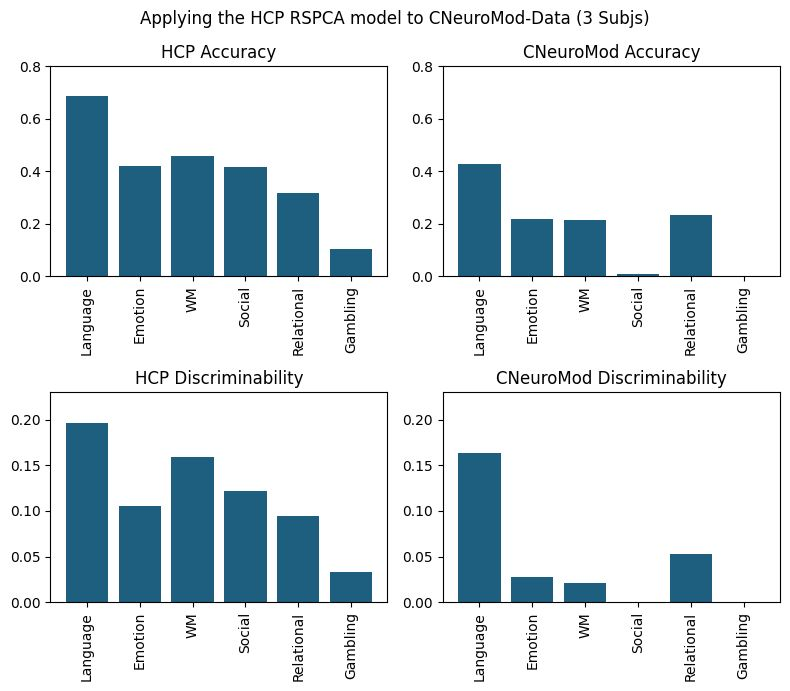

In [74]:
import cmasher as cmr
corr_CNEURO = scoresd.corr.mean(0)[:];
diff_CNEURO = diff_scores_test[:];

corr_HCP = regr_data_L[modality]["scoresd"]["corr"].mean(0)[cneuro_ctr_ids]
diff_HCP =  regr_data_L[modality]["diff_scores_test"][cneuro_ctr_ids];


fig, axs = plt.subplots(2,2, figsize=(8,3*2+1))
axs = np.array(axs).flatten()
titles=["HCP Accuracy", "CNeuroMod Accuracy", "HCP Discriminability", "CNeuroMod Discriminability"]
for i,data in enumerate([corr_HCP, corr_CNEURO, diff_HCP, diff_CNEURO]):
  axs[i].bar(np.arange(len(cneuro_ctr_ids)), data, color=cmr.pride(0.18))
  axs[i].set_xticks(np.arange(len(cneuromod_task_names)));
  axs[i].set_xticklabels( np.array(cneuromod_task_names), rotation=90);
  axs[i].set_title(titles[i])
    
for i in [0,1]: axs[i].set_ylim(0, 0.8)
for i in [2,3]: axs[i].set_ylim(0, 0.23)
plt.suptitle("Applying the HCP RSPCA model to CNeuroMod-Data (3 Subjs)")
plt.tight_layout()

In [54]:
corr_CNEURO

array([ 0.42577234,  0.21685098,  0.21421586,  0.00920233,  0.23167547,
       -0.01286513])

In [75]:
import pandas as pd

print("# HCP")
print("---- Accuracy (Correlation) ----",data.shape)
print(pd.DataFrame([corr_HCP.round(3)], index=[modality], columns=cneuromod_task_names))
print("\n---- Discrimanability ----",data.shape)
print(pd.DataFrame([diff_HCP.round(3)], index=[modality], columns=cneuromod_task_names))

print("\n\n# Cneuromod")
print("---- Accuracy (Correlation) ----",data.shape)
print(pd.DataFrame([corr_CNEURO.round(3)], index=[modality], columns=cneuromod_task_names))
print("\n---- Discrimanability ----",data.shape)
print(pd.DataFrame([diff_CNEURO.round(3)], index=[modality], columns=cneuromod_task_names))

# HCP
---- Accuracy (Correlation) ---- (6,)
           Language  Emotion     WM  Social  Relational  Gambling
RS-PCA200     0.688     0.42  0.456   0.417       0.318     0.102

---- Discrimanability ---- (6,)
           Language  Emotion     WM  Social  Relational  Gambling
RS-PCA200     0.196    0.105  0.159   0.122       0.094     0.033


# Cneuromod
---- Accuracy (Correlation) ---- (6,)
           Language  Emotion     WM  Social  Relational  Gambling
RS-PCA200     0.426    0.217  0.214   0.009       0.232    -0.013

---- Discrimanability ---- (6,)
           Language  Emotion     WM  Social  Relational  Gambling
RS-PCA200     0.164    0.028  0.021  -0.047       0.052    -0.011


## Fit new model on one subject and predict the other two 

In [76]:
# Fit model

#y_train, y_train_pred, y_test, y_test_pred, skr = predict_y_from_x(xdata, ydata, lmodel=lmodel, verbose=1)
x_train, x_test, y_train, y_test = train_test_split(xdata, ydata, test_size=0.6, shuffle=False)
x = x_train.reshape((-1, x_train.shape[-1]))

y = y_train.reshape((-1, y_train.shape[-1]))
skr = sklearn.linear_model.LinearRegression()
skr.fit(x, y)
xt = x_test.reshape((-1, x_test.shape[-1]))
y_test_pred =skr.predict(xt).reshape(y_test.shape)

scoresd, diff_scores_test = score(y_test_pred, y_test);

print(cneuromod_contrasts)
print("Correlation:", scoresd.corr.mean(0).round(3))
print("Differentiability:", diff_scores_test.round(3))

['LANGUAGE_STORY-MATH', 'EMOTION_FACES-SHAPES', 'WM_2BK-0BK', 'SOCIAL_TOM-RANDOM', 'RELATIONAL_REL-MATCH', 'GAMBLING_REWARD-PUNISH']
Correlation: [ 0.493  0.223  0.144 -0.05   0.06  -0.012]
Differentiability: [ 0.235  0.116  0.056 -0.006 -0.072 -0.004]


In [77]:
print("# Cneuromod: newly fit")
print("---- Accuracy (Correlation) ----",data.shape)
print(pd.DataFrame([scoresd.corr.mean(0).round(3)], index=[modality], columns=cneuromod_task_names))
print("\n---- Discrimanability ----",data.shape)
print(pd.DataFrame([diff_scores_test.round(3)], index=[modality], columns=cneuromod_task_names))

# Cneuromod: newly fit
---- Accuracy (Correlation) ---- (6,)
           Language  Emotion     WM  Social  Relational  Gambling
RS-PCA200     0.493    0.223  0.144   -0.05        0.06    -0.012

---- Discrimanability ---- (6,)
           Language  Emotion     WM  Social  Relational  Gambling
RS-PCA200     0.235    0.116  0.056  -0.006      -0.072    -0.004


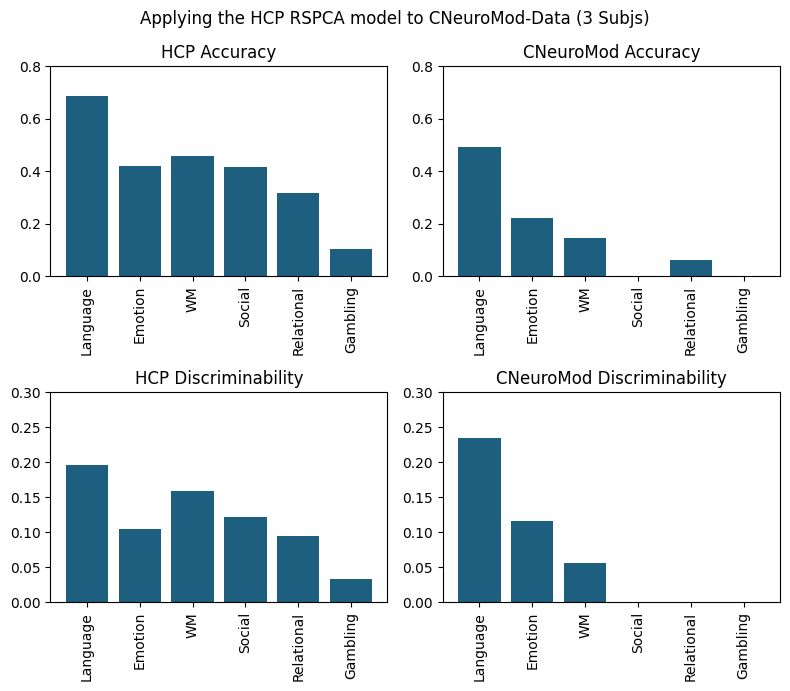

In [68]:
import cmasher as cmr
corr_CNEURO2 = scoresd.corr.mean(0)[:];
diff_CNEURO2 = diff_scores_test[:];

corr_HCP = regr_data_L[modality]["scoresd"]["corr"].mean(0)[cneuro_ctr_ids]
diff_HCP =  regr_data_L[modality]["diff_scores_test"][cneuro_ctr_ids];

fig, axs = plt.subplots(2,2, figsize=(8,3*2+1))
axs = np.array(axs).flatten()
titles=["HCP Accuracy", "CNeuroMod Accuracy", "HCP Discriminability", "CNeuroMod Discriminability"]
for i,data in enumerate([corr_HCP, corr_CNEURO2, diff_HCP, diff_CNEURO2]):
  axs[i].bar(np.arange(len(cneuro_ctr_ids)), data, color=cmr.pride(0.18))
  axs[i].set_xticks(np.arange(len(cneuromod_task_names)));
  axs[i].set_xticklabels( np.array(cneuromod_task_names), rotation=90);
  axs[i].set_title(titles[i])
    
for i in [0,1]: axs[i].set_ylim(0, 0.8)
for i in [2,3]: axs[i].set_ylim(0, 0.3)
plt.suptitle("Applying the HCP RSPCA model to CNeuroMod-Data (3 Subjs)")
plt.tight_layout()

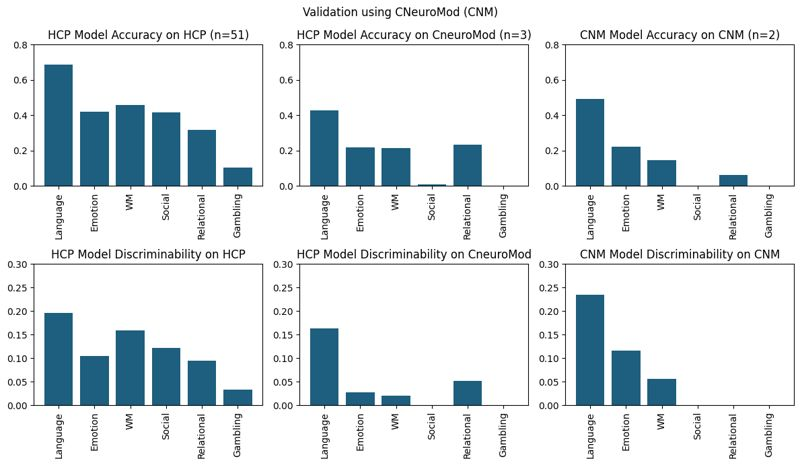

In [82]:
import cmasher as cmr
corr_CNEURO2 = scoresd.corr.mean(0)[:];
diff_CNEURO2 = diff_scores_test[:];

corr_HCP = regr_data_L[modality]["scoresd"]["corr"].mean(0)[cneuro_ctr_ids]
diff_HCP =  regr_data_L[modality]["diff_scores_test"][cneuro_ctr_ids];

fig, axs = plt.subplots(2,3, figsize=(8*1.5,3*2+1))
axs = np.array(axs).flatten()
titles=["HCP Model Accuracy on HCP (n=51)", "HCP Model Accuracy on CneuroMod (n=3)", "CNM Model Accuracy on CNM (n=2)", \
        "HCP Model Discriminability on HCP", "HCP Model Discriminability on CneuroMod", "CNM Model Discriminability on CNM"]
for i,data in enumerate([corr_HCP, corr_CNEURO, corr_CNEURO2, diff_HCP, diff_CNEURO, diff_CNEURO2]):
  axs[i].bar(np.arange(len(cneuro_ctr_ids)), data, color=cmr.pride(0.18))
  axs[i].set_xticks(np.arange(len(cneuromod_task_names)));
  axs[i].set_xticklabels( np.array(cneuromod_task_names), rotation=90);
  axs[i].set_title(titles[i])
    
for i in [0,1,2]: axs[i].set_ylim(0, 0.8)
for i in [3,4,5]: axs[i].set_ylim(0, 0.3)
plt.suptitle("Validation using CNeuroMod (CNM)")
plt.tight_layout()

**looking at the weights**

In [83]:
import cmasher as cmr
cmap_coeffs = "cmr.prinsenvlag_r" #cmc.vik #"PiYG"
n_comps = 30;

In [87]:
np.save("cneuro_single_subj_coeffs.npy", skr.coef_[:,:n_comps])

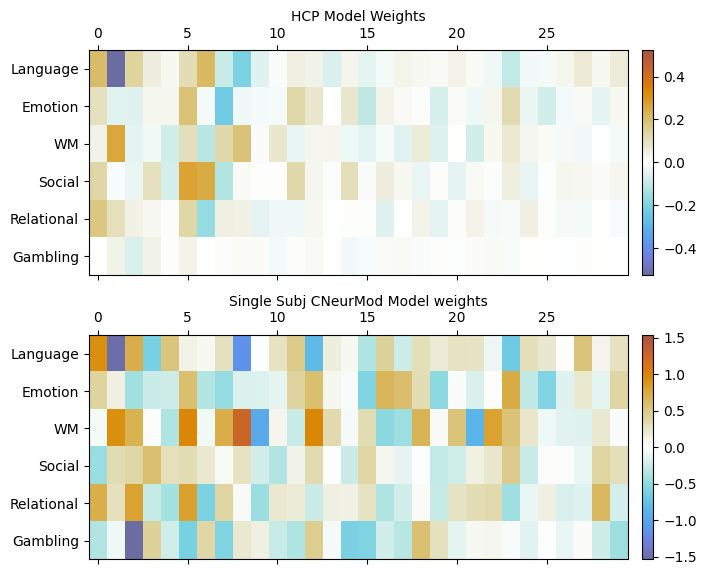

In [85]:
fig, axs = plt.subplots(2,1, figsize=(8,3.9*1.5)) # 4 plots in a row
data1 = coeffs_L[cneuro_ctr_ids,:n_comps]
data2 = skr.coef_[:,:n_comps]


titles=[f"HCP Model Weights", "Single Subj CNeurMod Model weights"];
for i, data in enumerate([data1, data2]):
    v = np.absolute(np.concatenate((data))).max()
    aspr=(data.shape[1]/data.shape[0])/2.4
    im = axs[i].matshow(data, cmap = cmap_coeffs, vmin=-v, vmax=v, aspect=aspr); 
    plt.colorbar(im,fraction=0.020, pad=0.02, ax=axs[i])
    axs[i].set_yticks(np.arange(len(cneuromod_task_names))); axs[i].set_yticklabels( cneuromod_task_names);
    axs[i].set_xlabel(titles[i]); axs[i].xaxis.set_label_position('top') 
    plt.tight_layout()

In [93]:
coeffs_CN = skr.coef_[:,:n_comps]
HCP = coeffs_L[cneuro_ctr_ids,:n_comps]

from brainspace.gradient.alignment import ProcrustesAlignment

alignment = ProcrustesAlignment(verbose=False, n_iter = 10)

coeffsCN2HCP = alignment.fit([coeffs_CN], HCP).aligned_[0]
coeffsCN2HCP.shape

(6, 30)

In [103]:
# for CNEURO

coeffs_CNEURO = coeffsCN2HCP#skr.coef_[:,:n_comps]

idxs = np.argsort(np.abs(coeffs_CNEURO), axis=1)
for n in range(len(cneuromod_task_names)):
  tn = contrast_ids_to_show[n]
  txt = f"ten biggest coeffs for {cneuromod_task_names[n]} ";
  print(txt, (44-len(txt))*" ", "at components:\t", idxs[n][::-1][:10])

print("----")
idxs = np.argsort(np.abs(coeffs_CNEURO), axis=1)
for n in range(len(cneuromod_task_names)):
  txt = f"ten biggest coeffs for {cneuromod_task_names[n]} ";
  tn = contrast_ids_to_show[n]
  print(txt, (35-len(txt))*" ", "at components:\t", end="")
  for c in idxs[n][::-1][:9]:
     print(f"c{c}", coeffs_CNEURO[n, c].round(3), end=" | ")
  print("")

ten biggest coeffs for Language               at components:	 [ 1  0  2  8 23  6  9 18 13 20]
ten biggest coeffs for Emotion                at components:	 [ 7 23  5 11 15 25  6  2 19 12]
ten biggest coeffs for WM                     at components:	 [ 1  8  5  7 10  4 21  0  6 18]
ten biggest coeffs for Social                 at components:	 [ 1  5  6  8  4 14 20 23 11 15]
ten biggest coeffs for Relational             at components:	 [ 0  6  5  2 16  7  9 24 21 18]
ten biggest coeffs for Gambling               at components:	 [ 2  0 14  3 22 16 17 10  9 15]
----
ten biggest coeffs for Language      at components:	c1 -2.222 | c0 0.964 | c2 0.757 | c8 -0.739 | c23 -0.561 | c6 0.476 | c9 -0.314 | c18 0.28 | c13 -0.267 | 
ten biggest coeffs for Emotion       at components:	c7 -1.187 | c23 0.713 | c5 0.622 | c11 0.603 | c15 -0.6 | c25 -0.462 | c6 -0.437 | c2 -0.436 | c19 -0.394 | 
ten biggest coeffs for WM            at components:	c1 1.456 | c8 1.356 | c5 1.049 | c7 0.934 | c10 0.684 | c4 